In [1]:
import os
import gc
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

Using Apple Metal Performance Shaders (MPS) device.


# Config

In [3]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=1000,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=6002,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=None,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

if opt.ckpt:
    ckpt_file = RESULT_DIR / opt.ckpt / "latest.pt"
    assert ckpt_file.exists()
    opt.load = ckpt_file
else:
    opt.load = None

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



# Prepare Data

In [4]:
from data import SuperResolutionDataset

# build dataset    
hr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_drone.npy'
lr_latent_path = 'data/one_meter_naip/224naip_latent_dataset_satellite.npy'
hr_latent = np.load(hr_latent_path, mmap_mode='r') # shape (B, C, H, W)
lr_latent = np.load(lr_latent_path, mmap_mode='r')
assert len(hr_latent) == len(lr_latent), f"hr_latent b={hr_latent.shape[0]} and lr_latent b={lr_latent.shape[0]} don't have the same B"
print(f"hr_latent shape: {hr_latent.shape}")
print("hr_latent  min/max:", hr_latent.min(), hr_latent.max())
print("lr_latent  min/max:", lr_latent.min(), lr_latent.max())

B = len(hr_latent)
split = int(0.9*B) # 90:10 train:test split

# shuffle loaded data before split
rng = np.random.default_rng(seed=42)
perm = rng.permutation(B)
train_idx = perm[:split]
val_idx = perm[split:]

train_hr, val_hr = hr_latent[train_idx], hr_latent[val_idx]
train_lr, val_lr = lr_latent[train_idx], lr_latent[val_idx]

train = SuperResolutionDataset(hr_images=train_hr, lr_images=train_lr, transform=None)
val = SuperResolutionDataset(hr_images=val_hr, lr_images=val_lr, transform=None)
print(f"Dataset lengths: train={len(train)} val={len(val)}")

del train_hr, val_hr, train_lr, val_lr, hr_latent, lr_latent
gc.collect()

hr_latent shape: (45540, 256, 14, 14)
hr_latent  min/max: -4.6789246 3.7865307
lr_latent  min/max: -0.8591689 0.95344883
Dataset lengths: train=40986 val=4554


113

In [5]:
from i2sb.runner import Runner

# build runner
run = Runner(opt)
# train
train_loss, eval_loss = run.train(opt, train, val)


/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Built schrodinger_bridge Diffusion Model with 1000 steps and i2sb beta schedule!


train_inner_loop: 100%|██████████| 64/64 [03:20<00:00,  3.13s/it]  


train_it 1/6002 | lr:5.00e-05 | noise_prediction_loss:+156.9812
Saved weights and losses on iteration 0


eval_inner_loop: 100%|██████████| 64/64 [02:12<00:00,  2.07s/it]


EVALUATE: eval_it 1/6002 | noise_prediction_loss:+114.3964 | reconstruction_loss:+24.9036


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 73.13it/s]


train_it 2/6002 | lr:5.00e-05 | noise_prediction_loss:+127.9991


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.34it/s]


train_it 3/6002 | lr:5.00e-05 | noise_prediction_loss:+78.3812


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 47.15it/s]


train_it 4/6002 | lr:5.00e-05 | noise_prediction_loss:+65.6697


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 50.06it/s]


train_it 5/6002 | lr:5.00e-05 | noise_prediction_loss:+43.0869


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 53.80it/s]


train_it 6/6002 | lr:5.00e-05 | noise_prediction_loss:+33.1050


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.32it/s]


train_it 7/6002 | lr:5.00e-05 | noise_prediction_loss:+24.5044


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.68it/s]


train_it 8/6002 | lr:5.00e-05 | noise_prediction_loss:+18.9286


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 56.98it/s]


train_it 9/6002 | lr:5.00e-05 | noise_prediction_loss:+15.2989


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 48.08it/s]


train_it 10/6002 | lr:5.00e-05 | noise_prediction_loss:+14.5108


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 57.03it/s]


train_it 51/6002 | lr:5.00e-05 | noise_prediction_loss:+2.0760


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 73.14it/s]


train_it 101/6002 | lr:5.00e-05 | noise_prediction_loss:+1.1862


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 59.94it/s]


train_it 151/6002 | lr:5.00e-05 | noise_prediction_loss:+0.9406


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 64.59it/s]


train_it 201/6002 | lr:5.00e-05 | noise_prediction_loss:+0.8185


eval_inner_loop: 100%|██████████| 64/64 [02:17<00:00,  2.15s/it]


EVALUATE: eval_it 201/6002 | noise_prediction_loss:+0.8136 | reconstruction_loss:+0.2721


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 72.06it/s]


train_it 251/6002 | lr:5.00e-05 | noise_prediction_loss:+0.7663


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 76.99it/s]


train_it 301/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6908


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 99.42it/s] 


train_it 351/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6789


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 100.12it/s]


train_it 401/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6858


eval_inner_loop: 100%|██████████| 64/64 [02:37<00:00,  2.46s/it]


EVALUATE: eval_it 401/6002 | noise_prediction_loss:+0.7018 | reconstruction_loss:+0.1973


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 53.27it/s]


train_it 451/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6887


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 104.33it/s]


train_it 501/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6367


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 93.78it/s] 


train_it 551/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6560


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 40.03it/s]


train_it 601/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6354


eval_inner_loop: 100%|██████████| 64/64 [03:26<00:00,  3.23s/it]


EVALUATE: eval_it 601/6002 | noise_prediction_loss:+0.6340 | reconstruction_loss:+0.1902


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 104.08it/s]


train_it 651/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6135


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 133.65it/s]


train_it 701/6002 | lr:5.00e-05 | noise_prediction_loss:+0.5995


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 13.74it/s]


train_it 751/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6142


train_inner_loop: 100%|██████████| 64/64 [04:01<00:00,  3.77s/it]


train_it 801/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6318


eval_inner_loop: 100%|██████████| 64/64 [02:46<00:00,  2.61s/it]


EVALUATE: eval_it 801/6002 | noise_prediction_loss:+0.6194 | reconstruction_loss:+0.1884


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.39it/s]


train_it 851/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6205


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 53.28it/s]


train_it 901/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6026


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.99it/s]


train_it 951/6002 | lr:5.00e-05 | noise_prediction_loss:+0.6313


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 95.95it/s] 


train_it 1001/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6208
Saved weights and losses on iteration 1000


eval_inner_loop: 100%|██████████| 64/64 [03:26<00:00,  3.23s/it]


EVALUATE: eval_it 1001/6002 | noise_prediction_loss:+0.6254 | reconstruction_loss:+0.1918


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 54.86it/s]


train_it 1051/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6114


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 52.47it/s]


train_it 1101/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6019


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 107.03it/s]


train_it 1151/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6080


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 122.86it/s]


train_it 1201/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5896


eval_inner_loop: 100%|██████████| 64/64 [04:10<00:00,  3.92s/it]


EVALUATE: eval_it 1201/6002 | noise_prediction_loss:+0.6243 | reconstruction_loss:+0.1889


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 52.14it/s]


train_it 1251/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6215


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 98.04it/s] 


train_it 1301/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6419


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 113.59it/s]


train_it 1351/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5647


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 28.71it/s]


train_it 1401/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6021


eval_inner_loop: 100%|██████████| 64/64 [03:19<00:00,  3.12s/it]


EVALUATE: eval_it 1401/6002 | noise_prediction_loss:+0.5941 | reconstruction_loss:+0.1812


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 116.03it/s]


train_it 1451/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5969


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 102.30it/s]


train_it 1501/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5842


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 14.26it/s]


train_it 1551/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5866


train_inner_loop: 100%|██████████| 64/64 [04:04<00:00,  3.82s/it]


train_it 1601/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6101


eval_inner_loop: 100%|██████████| 64/64 [02:44<00:00,  2.57s/it]


EVALUATE: eval_it 1601/6002 | noise_prediction_loss:+0.5882 | reconstruction_loss:+0.1777


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 40.28it/s]


train_it 1651/6002 | lr:4.95e-05 | noise_prediction_loss:+0.6003


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 55.86it/s]


train_it 1701/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5720


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.78it/s]


train_it 1751/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5912


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 110.96it/s]


train_it 1801/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5934


eval_inner_loop: 100%|██████████| 64/64 [03:35<00:00,  3.37s/it]


EVALUATE: eval_it 1801/6002 | noise_prediction_loss:+0.5664 | reconstruction_loss:+0.1851


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 54.76it/s]


train_it 1851/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5885


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 53.71it/s]


train_it 1901/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5915


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 133.40it/s]


train_it 1951/6002 | lr:4.95e-05 | noise_prediction_loss:+0.5770


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 114.60it/s]


train_it 2001/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5759
Saved weights and losses on iteration 2000


eval_inner_loop: 100%|██████████| 64/64 [03:56<00:00,  3.70s/it]


EVALUATE: eval_it 2001/6002 | noise_prediction_loss:+0.5851 | reconstruction_loss:+0.1718


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 47.50it/s]


train_it 2051/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5893


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 110.95it/s]


train_it 2101/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5777


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 107.70it/s]


train_it 2151/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5776


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 18.08it/s]


train_it 2201/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5930


eval_inner_loop: 100%|██████████| 64/64 [03:42<00:00,  3.48s/it]


EVALUATE: eval_it 2201/6002 | noise_prediction_loss:+0.5859 | reconstruction_loss:+0.1696


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 125.73it/s]


train_it 2251/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5724


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 107.31it/s]


train_it 2301/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5761


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 15.83it/s]


train_it 2351/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5826


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 50.02it/s]


train_it 2401/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5816


eval_inner_loop: 100%|██████████| 64/64 [02:59<00:00,  2.80s/it]


EVALUATE: eval_it 2401/6002 | noise_prediction_loss:+0.6121 | reconstruction_loss:+0.1676


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 100.27it/s]


train_it 2451/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5519


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 81.53it/s] 


train_it 2501/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5730


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 33.49it/s]


train_it 2551/6002 | lr:4.90e-05 | noise_prediction_loss:+0.6016


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 114.06it/s]


train_it 2601/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5583


eval_inner_loop: 100%|██████████| 64/64 [03:33<00:00,  3.34s/it]


EVALUATE: eval_it 2601/6002 | noise_prediction_loss:+0.5638 | reconstruction_loss:+0.1662


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 54.31it/s]


train_it 2651/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5732


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 56.03it/s]


train_it 2701/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5692


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 110.39it/s]


train_it 2751/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5817


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 122.73it/s]


train_it 2801/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5529


eval_inner_loop: 100%|██████████| 64/64 [03:37<00:00,  3.40s/it]


EVALUATE: eval_it 2801/6002 | noise_prediction_loss:+0.5387 | reconstruction_loss:+0.1584


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 52.45it/s]


train_it 2851/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5645


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 92.45it/s]


train_it 2901/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5588


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 89.08it/s]


train_it 2951/6002 | lr:4.90e-05 | noise_prediction_loss:+0.5319


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 28.65it/s]


train_it 3001/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5342
Saved weights and losses on iteration 3000


eval_inner_loop: 100%|██████████| 64/64 [03:53<00:00,  3.64s/it]


EVALUATE: eval_it 3001/6002 | noise_prediction_loss:+0.5450 | reconstruction_loss:+0.1563


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 108.30it/s]


train_it 3051/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5486


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 85.85it/s]


train_it 3101/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5455


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 59.22it/s]


train_it 3151/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5705


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 49.62it/s]


train_it 3201/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5406


eval_inner_loop: 100%|██████████| 64/64 [03:11<00:00,  2.99s/it]


EVALUATE: eval_it 3201/6002 | noise_prediction_loss:+0.5547 | reconstruction_loss:+0.1541


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 95.72it/s] 


train_it 3251/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5630


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 100.16it/s]


train_it 3301/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5350


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 42.01it/s]


train_it 3351/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5731


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 101.38it/s]


train_it 3401/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5209


eval_inner_loop: 100%|██████████| 64/64 [01:54<00:00,  1.79s/it]


EVALUATE: eval_it 3401/6002 | noise_prediction_loss:+0.5168 | reconstruction_loss:+0.1526


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 54.00it/s]


train_it 3451/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5366


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 61.64it/s]


train_it 3501/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5381


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 107.11it/s]


train_it 3551/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5190


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 135.92it/s]


train_it 3601/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5330


eval_inner_loop: 100%|██████████| 64/64 [01:20<00:00,  1.26s/it]


EVALUATE: eval_it 3601/6002 | noise_prediction_loss:+0.5375 | reconstruction_loss:+0.1517


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 81.47it/s]


train_it 3651/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5585


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 114.20it/s]


train_it 3701/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5370


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 117.11it/s]


train_it 3751/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5008


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.08it/s]


train_it 3801/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5242


eval_inner_loop: 100%|██████████| 64/64 [01:37<00:00,  1.52s/it]


EVALUATE: eval_it 3801/6002 | noise_prediction_loss:+0.5175 | reconstruction_loss:+0.1481


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 121.88it/s]


train_it 3851/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5539


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 120.30it/s]


train_it 3901/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5460


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 141.15it/s]


train_it 3951/6002 | lr:4.85e-05 | noise_prediction_loss:+0.5479


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 140.87it/s]


train_it 4001/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5305
Saved weights and losses on iteration 4000


eval_inner_loop: 100%|██████████| 64/64 [01:39<00:00,  1.55s/it]


EVALUATE: eval_it 4001/6002 | noise_prediction_loss:+0.5557 | reconstruction_loss:+0.1465


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 109.97it/s]


train_it 4051/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5316


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 141.60it/s]


train_it 4101/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5393


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.80it/s]


train_it 4151/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5190


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 117.37it/s]


train_it 4201/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5528


eval_inner_loop: 100%|██████████| 64/64 [01:20<00:00,  1.25s/it]


EVALUATE: eval_it 4201/6002 | noise_prediction_loss:+0.5221 | reconstruction_loss:+0.1486


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 91.08it/s] 


train_it 4251/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5640


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 52.60it/s]


train_it 4301/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5462


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 143.01it/s]


train_it 4351/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5538


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 90.90it/s]


train_it 4401/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5632


eval_inner_loop: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it]


EVALUATE: eval_it 4401/6002 | noise_prediction_loss:+0.5565 | reconstruction_loss:+0.1409


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 84.21it/s]


train_it 4451/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5110


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 101.60it/s]


train_it 4501/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5307


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 118.03it/s]


train_it 4551/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5350


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 138.19it/s]


train_it 4601/6002 | lr:4.80e-05 | noise_prediction_loss:+0.4998


eval_inner_loop: 100%|██████████| 64/64 [01:36<00:00,  1.51s/it]


EVALUATE: eval_it 4601/6002 | noise_prediction_loss:+0.5110 | reconstruction_loss:+0.1414


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 119.49it/s]


train_it 4651/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5169


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 141.19it/s]


train_it 4701/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5245


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 116.36it/s]


train_it 4751/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5208


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.98it/s]


train_it 4801/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5065


eval_inner_loop: 100%|██████████| 64/64 [01:33<00:00,  1.47s/it]


EVALUATE: eval_it 4801/6002 | noise_prediction_loss:+0.5327 | reconstruction_loss:+0.1404


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 87.49it/s] 


train_it 4851/6002 | lr:4.80e-05 | noise_prediction_loss:+0.4920


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.17it/s]


train_it 4901/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5206


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 96.43it/s] 


train_it 4951/6002 | lr:4.80e-05 | noise_prediction_loss:+0.5201


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 103.50it/s]


train_it 5001/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5152
Saved weights and losses on iteration 5000


eval_inner_loop: 100%|██████████| 64/64 [01:18<00:00,  1.22s/it]


EVALUATE: eval_it 5001/6002 | noise_prediction_loss:+0.5059 | reconstruction_loss:+0.1408


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 118.02it/s]


train_it 5051/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5235


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 51.87it/s]


train_it 5101/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4953


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 132.43it/s]


train_it 5151/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5079


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 100.44it/s]


train_it 5201/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5002


eval_inner_loop: 100%|██████████| 64/64 [01:22<00:00,  1.28s/it]


EVALUATE: eval_it 5201/6002 | noise_prediction_loss:+0.5263 | reconstruction_loss:+0.1356


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 106.24it/s]


train_it 5251/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5137


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 122.06it/s]


train_it 5301/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5019


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 105.96it/s]


train_it 5351/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5083


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 140.15it/s]


train_it 5401/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5170


eval_inner_loop: 100%|██████████| 64/64 [01:53<00:00,  1.78s/it]


EVALUATE: eval_it 5401/6002 | noise_prediction_loss:+0.5210 | reconstruction_loss:+0.1331


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 111.89it/s]


train_it 5451/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5123


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 101.65it/s]


train_it 5501/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5000


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 138.81it/s]


train_it 5551/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5278


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 118.58it/s]


train_it 5601/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5041


eval_inner_loop: 100%|██████████| 64/64 [01:36<00:00,  1.51s/it]


EVALUATE: eval_it 5601/6002 | noise_prediction_loss:+0.5039 | reconstruction_loss:+0.1342


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 138.64it/s]


train_it 5651/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4979


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 110.74it/s]


train_it 5701/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5146


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 139.92it/s]


train_it 5751/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4806


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 137.64it/s]


train_it 5801/6002 | lr:4.75e-05 | noise_prediction_loss:+0.5208


eval_inner_loop: 100%|██████████| 64/64 [01:18<00:00,  1.23s/it]


EVALUATE: eval_it 5801/6002 | noise_prediction_loss:+0.5334 | reconstruction_loss:+0.1308


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 90.29it/s] 


train_it 5851/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4792


train_inner_loop: 100%|██████████| 64/64 [00:01<00:00, 45.36it/s]


train_it 5901/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4899


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 134.23it/s]


train_it 5951/6002 | lr:4.75e-05 | noise_prediction_loss:+0.4868


train_inner_loop: 100%|██████████| 64/64 [00:00<00:00, 105.67it/s]


train_it 6001/6002 | lr:4.71e-05 | noise_prediction_loss:+0.4871
Saved weights and losses on iteration 6000


eval_inner_loop: 100%|██████████| 64/64 [01:21<00:00,  1.27s/it]


EVALUATE: eval_it 6001/6002 | noise_prediction_loss:+0.5054 | reconstruction_loss:+0.1289
Saved weights and losses on iteration 6001


In [6]:
del run
del train, val
gc.collect()

763

In [7]:
t_noise_pred_l = np.load('results/test/train_losses.npy')
ti = np.arange(0, len(t_noise_pred_l))

e = np.load('results/test/eval_losses.npy')
ei = e[:, 0].astype(int)
e_noise_pred_l = e[:, 1]
e_reconstruction_l = e[:, 2]

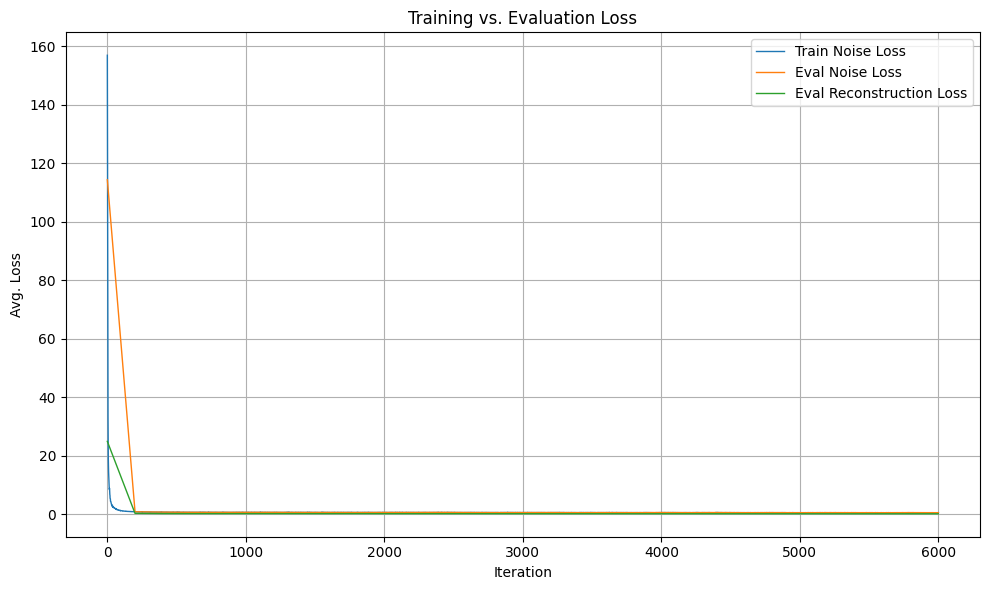

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(ti, t_noise_pred_l, label='Train Noise Loss', linewidth=1)
plt.plot(ei, e_noise_pred_l, label='Eval Noise Loss', linewidth=1)
plt.plot(ei, e_reconstruction_l, label='Eval Reconstruction Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Avg. Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

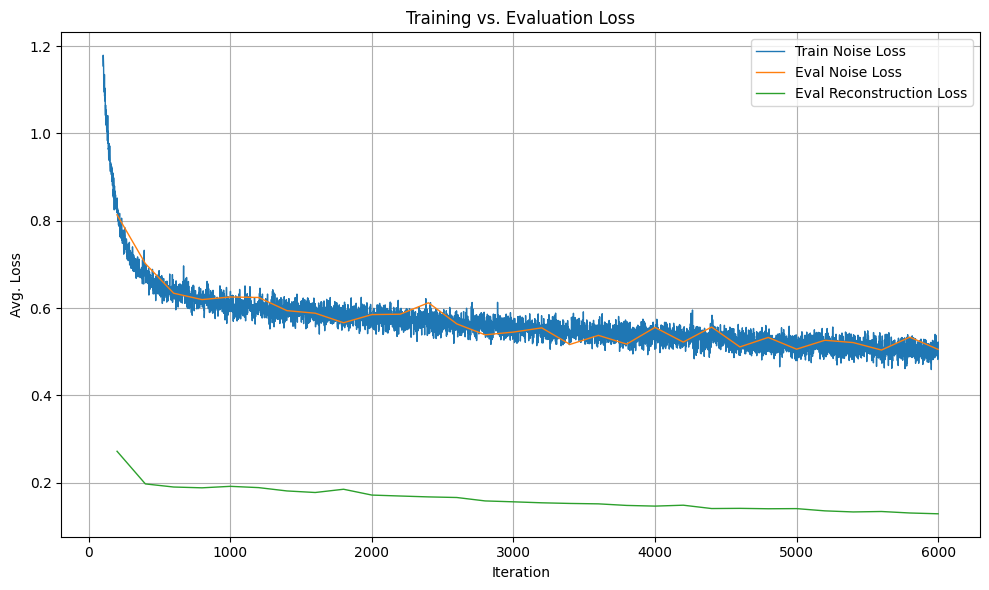

In [9]:
mask_t = ti > 100
mask_e = ei > 100

ti_masked = ti[mask_t]
t_noise_pred_l_masked = t_noise_pred_l[mask_t]
ei_masked = ei[mask_e]
e_noise_pred_l_masked = e_noise_pred_l[mask_e]
e_reconstruction_l_masked = e_reconstruction_l[mask_e]

plt.figure(figsize=(10, 6))
plt.plot(ti_masked, t_noise_pred_l_masked, label='Train Noise Loss', linewidth=1)
plt.plot(ei_masked, e_noise_pred_l_masked, label='Eval Noise Loss', linewidth=1)
plt.plot(ei_masked, e_reconstruction_l_masked, label='Eval Reconstruction Loss', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Avg. Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# # Image transition plotter
# # source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

# torch.manual_seed(opt.seed)
# def plot_images(imgs, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs[0], list):
#         # Make a 2d grid even if there's just 1 row
#         imgs = [imgs]

#     num_rows = len(imgs)
#     num_cols = len(imgs[0]) + with_orig
#     _, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
#     for row_idx, row in enumerate(imgs):
#         for col_idx, img in enumerate(row):
#             ax = axs[row_idx, col_idx]
#             ax.imshow(np.asarray(img), **imshow_kwargs)
#             ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
#     if row_title is not None:
#         for row_idx in range(num_rows):
#             axs[row_idx, 0].set(ylabel=row_title[row_idx])

#     plt.tight_layout()